*Exploratory Data Analysis*

# Visualizing the Sampling Strategy along Rays

In [1]:
import pickle
import os
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.markers as mmark

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, FancyArrow, ArrowStyle, Polygon
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import proj3d
from matplotlib.lines import Line2D
import torch
import itertools
import warnings
warnings.filterwarnings("ignore")

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from run_dnerf_helpers import get_rays
from utils.load_deepdeform import load_deepdeform_data, pose_spiral
from utils import Arrow3D, draw_transformed, draw_cam, draw_ray

%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.size": 15,
    "figure.titlesize": "x-large",
    "axes.titlesize": "large",
    "axes.labelsize": "small",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "figure.autolayout": True,          # does tight_layout
    })

Loading the validation logs.

In [4]:
# path = "logs/report_johannes_01_dnerf"
# path = "logs/report_johannes_05_mse_dgs"
path = "logs/report_johannes_14_gnll_larger_dgs"
# path = "logs/bottle_01_mse"

sampling_strategy = "Hierarchical Sampling"
with open(os.path.join(path, "args.txt"), "r") as f:
    for line in f:
        if "use_depth_guided_sampling = True" in line:
            sampling_strategy = "Depth Guided Sampling"

ray_pickles = sorted([p for p in os.listdir(path) if ".pickle" in p])
frame_logs = []
for ray_pickle in ray_pickles:
    load_p = os.path.join(path, ray_pickle)
    with open(load_p, "rb") as f:
        print("Loading rays from " + load_p)
        try:
            frame_logs.append(pickle.load(f))
        except pickle.UnpicklingError as e:
            print("UnpicklingError: pickle data was truncated")

print("Logged items (shape/value):")
frame_log = frame_logs[0]
for k in frame_log.keys():
    toprint = "\t\t" + k
    if isinstance(frame_log[k], torch.Tensor):
        toprint += "\t" + str(tuple(frame_log[k].shape))
    if isinstance(frame_log[k], float):
        toprint += "\t" + str(frame_log[k])
    print(toprint)

Loading rays from logs/report_johannes_14_gnll_larger_dgs/step_050000_ray_debug.pickle
Loading rays from logs/report_johannes_14_gnll_larger_dgs/step_100000_ray_debug.pickle
Loading rays from logs/report_johannes_14_gnll_larger_dgs/step_150000_ray_debug.pickle
Loading rays from logs/report_johannes_14_gnll_larger_dgs/step_200000_ray_debug.pickle
Loading rays from logs/report_johannes_14_gnll_larger_dgs/step_250000_ray_debug.pickle
Loading rays from logs/report_johannes_14_gnll_larger_dgs/step_300000_ray_debug.pickle
Loading rays from logs/report_johannes_14_gnll_larger_dgs/step_350000_ray_debug.pickle
Loading rays from logs/report_johannes_14_gnll_larger_dgs/step_400000_ray_debug.pickle
Logged items (shape/value):
		rays_o	(480, 360, 3)
		rays_d	(480, 360, 3)
		rgb_map	(480, 360, 3)
		depth_map	(480, 360, 1)
		z_coarse	(480, 360, 64)
		z_fine	(480, 360, 128)
		c2w	(3, 4)
		near	0.10000000149011612
		far	2.2141053676605225


In [7]:
cmap = [
    {"coarse": "#039BE5FF", "fine": "#0D47A1FF"},       # blue
    {"coarse": "#7CB342FF", "fine": "#33691EFF"},       # green
    {"coarse": "#FB8C00FF", "fine": "#E64A19FF"},       # orange
    {"coarse": "#BA68C8FF", "fine": "#4A148CFF"},       # purple
] 

def series(ith_frame):

    frame_log = frame_logs[ith_frame]
    
    H, W, _ = frame_log["rgb_map"].shape
    camera_pose = frame_log["c2w"]
    rays_o = frame_log["rays_o"]
    rays_d = frame_log["rays_d"]
    rgb_map = frame_log["rgb_map"]
    depth_map = frame_log["depth_map"]
    if "z_coarse" in frame_log:
        z_coarse = frame_log["z_coarse"]
        z_fine = frame_log["z_fine"]
    else:
        z_coarse = frame_log["z_vals"]
        z_fine = np.ndarray(z_coarse.shape)
        print("No coarse/fine samples. Loading combined values.")
        
    near = frame_log["near"]
    far = frame_log["far"]

    pts_coarse = rays_o[...,None,:] + rays_d[...,None,:] * z_coarse[...,:,None]
    pts_fine = rays_o[...,None,:] + rays_d[...,None,:] * z_fine[...,:,None]

    ith_rays = [(100, 100), (120, 150), (150, 200), (50, 270)]         # h, w

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 3)

    # Info
    info_str =  f"Exp.:  {path.split('/')[1]}\n"
    info_str += f"Step:  {ray_pickles[ith_frame].split('_')[1]}\n"
    info_str += f"Near: {near:.2f}\n"
    info_str += f"Far:    {far:.2f}"
    fig.text(x=0.7, y=0.07, s=info_str)

    # RGB img
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(rgb_map)
    for i, ith_ray in enumerate(ith_rays):
        ax0.scatter(*ith_ray[::-1], fc=cmap[i]["coarse"], ec=cmap[i]["fine"], s=50)
    ax0.set_title("Predicted RGB Image")
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)

    # Depth img
    ax0 = fig.add_subplot(gs[1, 0])
    dimg = ax0.imshow(depth_map)
    for i, ith_ray in enumerate(ith_rays):
        ax0.scatter(*ith_ray[::-1], fc=cmap[i]["coarse"], ec=cmap[i]["fine"], s=50)
    cax = fig.add_axes([0.4, 0.07, 0.2, 0.03])
    fig.colorbar(dimg, cax=cax, orientation='horizontal')
    ax0.set_title("Predicted Depth Map")
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)

    # 3D rays plot
    ax1 = fig.add_subplot(gs[:, 1:], projection='3d')
    # ax1.computed_zorder = False
    ax1.set_title(f"{len(ith_rays)} Sampled Camera Rays")

    xlim = [-1, 1]
    ylim = [-1, 1]
    zlim = [-1, 1]
    ax1.set_xlabel('X')
    ax1.set_xlim(*xlim)
    ax1.set_ylabel('Y')
    ax1.set_ylim(*ylim)
    ax1.set_zlabel('Z')
    ax1.set_zlim(*zlim)
    ax1.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))       # -> length of 1 in each dimension is visually the equal

    # The world coordinate system
    axes_len = 0.5
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='simple', shrinkA=0, shrinkB=0)
    ax1.add_artist(Arrow3D([0, axes_len], [0, 0], [0, 0], **arrow_prop_dict, color='r'))
    ax1.add_artist(Arrow3D([0, 0], [0, axes_len], [0, 0], **arrow_prop_dict, color='b'))
    ax1.add_artist(Arrow3D([0, 0], [0, 0], [0, axes_len], **arrow_prop_dict, color='g'))
    ax1.text(-0.1, -0.1, 0, r'$0$')
    ax1.text(axes_len, 0, 0, r'$x$')
    ax1.text(0, axes_len, 0, r'$y$')
    ax1.text(0, 0, axes_len, r'$z$')

    # Draw the camera coordinate frame
    tcx, tcy, tcz, _ = draw_transformed(camera_pose, ax1, arrowstyle='simple', axes_len=0.5, linewidth=1.5, mutation_scale=20, edgecolor="black")
    # Draw the camera
    draw_cam(rays_o, rays_d, ax1, focal_dist=0.5)       # rays_o and rays_d are already in world-coordinates


    # Draw a ray with its samples
    for i, ith_ray in enumerate(ith_rays):
        draw_ray(rays_o[ith_ray], rays_d[ith_ray], pts_coarse[ith_ray], pts_fine[ith_ray], depth_map[ith_ray], 
                 near, far, ax=ax1, coarse_c=cmap[i]["coarse"], fine_c=cmap[i]["fine"])

    # Make the legends
    black_triangle = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=13)
    lgnd1 = plt.legend(handles=[tcx, tcy, tcz, black_triangle], 
            labels=["X", "Y", "Z", "Estim. depth"], 
            title="Camera pose")
    plt.gca().add_artist(lgnd1)

    ax1.view_init(elev=30, azim=155, vertical_axis='x')        # only works with matplotlib >= 3.5
    #ax1.dist = 8

    fig.suptitle(f"{sampling_strategy} in the Global Coordinate System", )
    fig.tight_layout()      
    
    return fig

inter = interact(series, ith_frame=(0, len(frame_logs)-1, 1));

interactive(children=(IntSlider(value=3, description='ith_frame', max=7), Output()), _dom_classes=('widget-int…

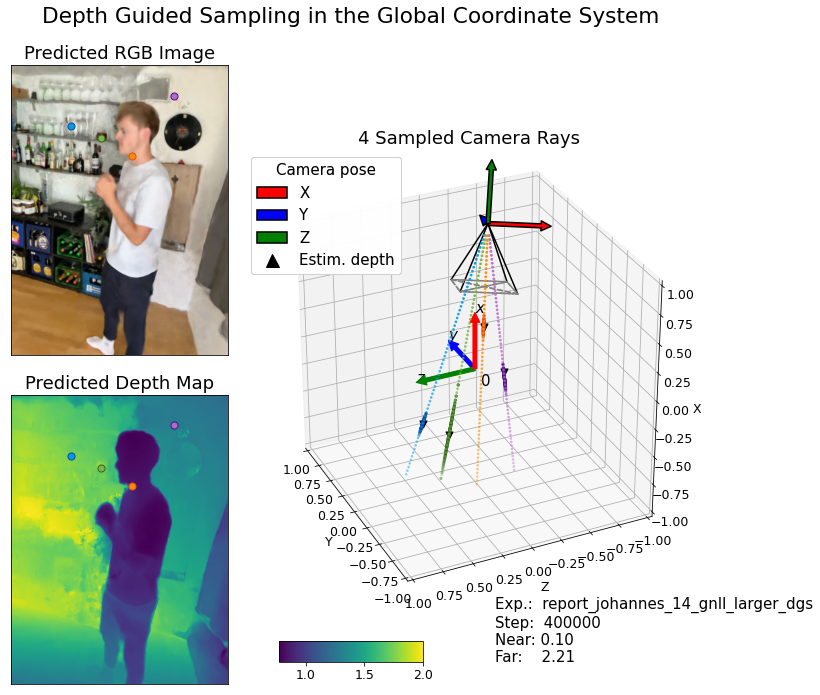

In [9]:
series(7).savefig("ray_sampling.png", dpi=200)